# Using the library(odd number of qubits)

This code tutorial shows how to estimate a 1-RDM and perform variational optimization

In [1]:
# Import library functions and define a helper function
import numpy as np
import cirq

from openfermioncirq.experiments.hfvqe.gradient_hf import rhf_func_generator
from openfermioncirq.experiments.hfvqe.opdm_functionals import OpdmFunctional
from openfermioncirq.experiments.hfvqe.analysis import (compute_opdm,
                            mcweeny_purification,
                            resample_opdm,
                            fidelity_witness,
                            fidelity)
from openfermioncirq.experiments.hfvqe.third_party.higham import fixed_trace_positive_projection
from openfermioncirq.experiments.hfvqe.molecular_example_odd_qubits import make_h3_2_5



### Generate the input files, set up quantum resources, and set up the OpdmFunctional to make measurements. 

In [2]:
rhf_objective, molecule, parameters, obi, tbi = make_h3_2_5()
ansatz, energy, gradient = rhf_func_generator(rhf_objective)

# settings for quantum resources
qubits = [cirq.GridQubit(0, x) for x in range(molecule.n_orbitals)]
sampler = cirq.Simulator(dtype=np.complex128)  # this can be a QuantumEngine

# OpdmFunctional contains an interface for running experiments
opdm_func = OpdmFunctional(qubits=qubits,
                           sampler=sampler,
                           constant=molecule.nuclear_repulsion,
                           one_body_integrals=obi,
                           two_body_integrals=tbi,
                           num_electrons=molecule.n_electrons // 2,  # only simulate spin-up electrons
                           clean_xxyy=True,
                           purification=True
                           )

Optimization terminated successfully.
         Current function value: -0.806205
         Iterations: 2
         Function evaluations: 7
         Gradient evaluations: 7


### The displayed text is the output of the gradient based restricted Hartree-Fock.  We define the gradient in `rhf_objective` and use the conjugate-gradient optimizer to optimize the basis rotation parameters.  This is equivalent to doing Hartree-Fock theory from the canonical transformation perspective.


Next, we will do the following:

1. Do measurements for a given set of parameters

2. Compute 1-RDM, variances, and purification

3. Compute energy, fidelities, and errorbars

In [3]:
# 1.
# default to 250_000 shots for each circuit.
# 7 circuits total, printed for your viewing pleasure
# return value is a dictionary with circuit results for each permutation

measurement_data = opdm_func.calculate_data(parameters)

# 2.
opdm, var_dict = compute_opdm(measurement_data,
                              return_variance=True)
opdm_pure = mcweeny_purification(opdm)


# 3.
raw_energies = []
raw_fidelity_witness = []
purified_eneriges = []
purified_fidelity_witness = []
purified_fidelity = []
true_unitary = ansatz(parameters)
nocc = molecule.n_electrons // 2
nvirt = molecule.n_orbitals - nocc

initial_fock_state = [1] * nocc + [0] * nvirt
for _ in range(1000):  # 1000 repetitions of the measurement
    new_opdm = resample_opdm(opdm, var_dict)
    raw_energies.append(opdm_func.energy_from_opdm(new_opdm))
    raw_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm)
    )
    # fix positivity and trace of sampled 1-RDM if strictly outside
    # feasible set
    w, v = np.linalg.eigh(new_opdm)
    if len(np.where(w < 0)[0]) > 0:
        new_opdm = fixed_trace_positive_projection(new_opdm, nocc)

    new_opdm_pure = mcweeny_purification(new_opdm)
    purified_eneriges.append(opdm_func.energy_from_opdm(new_opdm_pure))
    purified_fidelity_witness.append(
        fidelity_witness(target_unitary=true_unitary,
                         omega=initial_fock_state,
                         measured_opdm=new_opdm_pure)
    )
    purified_fidelity.append(
        fidelity(target_unitary=true_unitary,
                 measured_opdm=new_opdm_pure)
    )
print('\n\n\n\n')
print("Canonical Hartree-Fock energy ", molecule.hf_energy)
print("True energy ", energy(parameters))
print("Raw energy ", opdm_func.energy_from_opdm(opdm),
      "+- ", np.std(raw_energies))
print("Raw fidelity witness ", np.mean(raw_fidelity_witness).real,
      "+- ", np.std(raw_fidelity_witness))
print("purified energy ", opdm_func.energy_from_opdm(opdm_pure),
      "+- ", np.std(purified_eneriges))
print("Purified fidelity witness ", np.mean(purified_fidelity_witness).real,
      "+- ", np.std(purified_fidelity_witness))
print("Purified fidelity ", np.mean(purified_fidelity).real,
      "+- ", np.std(purified_fidelity))







Canonical Hartree-Fock energy  -0.8062049864800688
True energy  -0.8062049864970051
Raw energy  -0.8054758202710877 +-  0.0002841083507287418
Raw fidelity witness  0.997393469661081 +-  0.0010070261792183542
purified energy  -0.8062048209660764 +-  1.2912146958194106e-06
Purified fidelity witness  0.9999970348375896 +-  2.965096636692094e-06
Purified fidelity  0.9999985176409273 +-  1.482555363905694e-06


This should print out the various energies estimated from the 1-RDM along with error bars.  Generated from resampling the 1-RDM based on the estimated covariance.

## Optimization

We use the sampling functionality to variationally relax the parameters of
my ansatz such that the energy is decreased.

For this we will need the augmented Hessian optimizer

The optimizerer code we have takes:
rhf_objective object, initial parameters,
a function that takes a n x n unitary and returns an opdm
maximum iterations,
hassian_update which indicates how much of the hessian to use
rtol which is the gradient stopping condition.

A natural thing that we will want to save is the variance dictionary of
the non-purified 1-RDM.  This is accomplished by wrapping the 1-RDM
estimation code in another object that keeps track of the variance 
dictionaries. 


In [4]:
from openfermioncirq.experiments.hfvqe.mfopt import moving_frame_augmented_hessian_optimizer
from openfermioncirq.experiments.hfvqe.opdm_functionals import RDMGenerator
import matplotlib.pyplot as plt
rdm_generator = RDMGenerator(opdm_func, purification=True)
opdm_generator = rdm_generator.opdm_generator

result = moving_frame_augmented_hessian_optimizer(
    rhf_objective=rhf_objective,
    initial_parameters= parameters + 5.0E-1 ,
    opdm_aa_measurement_func=opdm_generator,
    verbose=True, delta=0.03,
    max_iter=120,
    hessian_update='diagonal',
    rtol=0.050E-2)



ITERATION NUMBER :  0

 unitary
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Current Energy:  -0.45436924460009553
true energy  -0.45436924460009553
dvec
[((0.39747996513551487+0j), -1.0 [0^ 2] +
-1.0 [1^ 3] +
1.0 [2^ 0] +
1.0 [3^ 1]), ((0.32335512526654964+0j), -1.0 [0^ 4] +
-1.0 [1^ 5] +
1.0 [4^ 0] +
1.0 [5^ 1])]
New fr values norm
0.030175860543567117

ITERATION NUMBER :  1

 unitary
[[ 0.37140703 -0.39002425 -0.84257813]
 [ 0.39002425  0.88907822 -0.23962682]
 [ 0.84257813 -0.23962682  0.48232881]]
Current Energy:  -0.46596649780370336
true energy  -0.46596649780370336
dvec
[((0.4283566728607223+0j), -1.0 [0^ 2] +
-1.0 [1^ 3] +
1.0 [2^ 0] +
1.0 [3^ 1]), ((0.3596304423055997+0j), -1.0 [0^ 4] +
-1.0 [1^ 5] +
1.0 [4^ 0] +
1.0 [5^ 1])]
New fr values norm
0.030306456722012667

ITERATION NUMBER :  2

 unitary
[[ 0.39778004 -0.39414259 -0.82850628]
 [ 0.38877304  0.89035379 -0.23690852]
 [ 0.83103945 -0.22786342  0.50739698]]
Current Energy:  -0.47916395109600596
true energy  -0.4791639510960059


ITERATION NUMBER :  20

 unitary
[[ 0.8164346  -0.08887438 -0.57055753]
 [ 0.12078645  0.99251097  0.01823732]
 [ 0.56466378 -0.08380519  0.82105512]]
Current Energy:  -0.7983513586536213
true energy  -0.7983513586536213
dvec
[((0.13276919960905492+0j), -1.0 [0^ 2] +
-1.0 [1^ 3] +
1.0 [2^ 0] +
1.0 [3^ 1]), ((0.0448684927005671+0j), -1.0 [0^ 4] +
-1.0 [1^ 5] +
1.0 [4^ 0] +
1.0 [5^ 1])]
New fr values norm
0.030679898099457075

ITERATION NUMBER :  21

 unitary
[[ 0.82441844 -0.05976676 -0.56281628]
 [ 0.09617166  0.99474077  0.0352393 ]
 [ 0.55775016 -0.0831789   0.82583051]]
Current Energy:  -0.8020134704015441
true energy  -0.8020134704015441
dvec
[((0.09711166062685768+0j), -1.0 [0^ 2] +
-1.0 [1^ 3] +
1.0 [2^ 0] +
1.0 [3^ 1]), ((0.022640869122894106+0j), -1.0 [0^ 4] +
-1.0 [1^ 5] +
1.0 [4^ 0] +
1.0 [5^ 1])]
New fr values norm
0.03031190660242576

ITERATION NUMBER :  22

 unitary
[[ 0.8304971  -0.03043528 -0.55619085]
 [ 0.07134598  0.99609391  0.05202572]
 [ 0.5524349  -0.08288919  0.

Each interation prints out a variety of information that the user might find useful.  Watching energies go down is known to be one of the best forms of entertainment during a shelter-in-place order.

After the optimization we can print the energy as a function of iteration number to see close the energy gets to the true minium.

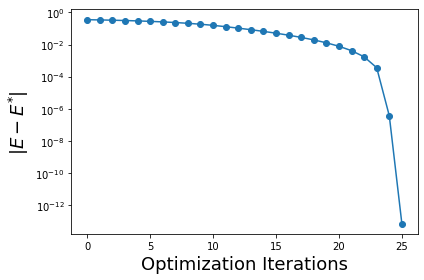

In [5]:
plt.semilogy(range(len(result.func_vals)),
             np.abs(np.array(result.func_vals) - energy(parameters)),
             'C0o-')
plt.xlabel("Optimization Iterations",  fontsize=18)
plt.ylabel(r"$|E  - E^{*}|$", fontsize=18)
plt.tight_layout()
plt.show()